<h1>Importing essential libraries</h1>

In [1]:
import sys
!{sys.executable} -m pip install pandas-profiling
!{sys.executable} -m pip install plotly
!{sys.executable} -m pip  install catboost

You should consider upgrading via the '/usr/local/bin/python3.9 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/local/bin/python3.9 -m pip install --upgrade pip' command.


You should consider upgrading via the '/usr/local/bin/python3.9 -m pip install --upgrade pip' command.


In [1]:
# Importing essential libraries
import numpy as np
import pandas as pd
import seaborn as sns
import pandas_profiling
import matplotlib.pyplot as plt

# Importing various models and tools 
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier 

sns.set()
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

# Importing Dataset

We import the dataset that has been cleaned and does not contain any duplicates.

In [2]:
wine_data = pd.read_csv("binned_no_dup.csv")

wine_data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,1
4,7.4,0.66,0.00,1.8,0.075,13.0,40.0,0.9978,3.51,0.56,9.4,0


## Outlier removal
We can remove the outliers for each predictor variable in our dataset, so that our trained models will not be impacted by the outliers. We do this by removing data points with predictor variable values beyond 1.5 * IQR of the first or third quartile. This leaves us with a decent 1019 datapoints remaining.

In [3]:
# Cleaning dataset: Removing outliers
wine_predictors = wine_data.drop('quality', axis = 1)
wine_quality = wine_data['quality']


Q1_joint = wine_predictors.quantile(0.25)
Q3_joint = wine_predictors.quantile(0.75)
IQR_joint = Q3_joint - Q1_joint
idx_joint_cleaned = ~((wine_predictors < (Q1_joint - 1.5 * IQR_joint)) | (wine_predictors > (Q3_joint + 1.5 * IQR_joint))).any(axis=1)

wine_predictors_cleaned = wine_predictors.loc[idx_joint_cleaned]

wine_data_cleaned = wine_predictors_cleaned.join(wine_quality)

wine_data_cleaned.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1019.000000,1019.000000,1019.000000,1019.000000,1019.000000,1019.000000,1019.000000,1019.000000,1019.000000,1019.000000,1019.000000,1019.000000
mean,8.169872,0.522507,0.250805,2.198822,0.078452,14.959764,42.388616,0.996547,3.322385,0.631237,10.385967,0.538763
std,1.475073,0.167364,0.182313,0.452214,0.014973,8.838951,26.625802,0.001616,0.132589,0.114861,0.992372,0.498740
min,5.100000,0.120000,0.000000,1.200000,0.039000,1.000000,6.000000,0.992350,2.940000,0.330000,8.700000,0.000000
25%,7.100000,0.390000,0.080000,1.900000,0.069000,8.000000,22.000000,0.995500,3.230000,0.550000,9.500000,0.000000
50%,7.800000,0.520000,0.240000,2.100000,0.078000,13.000000,36.000000,0.996560,3.320000,0.610000,10.100000,1.000000
75%,9.000000,0.630000,0.400000,2.500000,0.087000,20.000000,56.000000,0.997600,3.400000,0.700000,11.000000,1.000000
max,12.300000,1.010000,0.730000,3.650000,0.122000,42.000000,124.000000,1.001000,3.680000,0.980000,13.400000,1.000000


([<matplotlib.axis.XTick at 0x190455fe070>,
 <a list of 2 Text major ticklabel objects>)

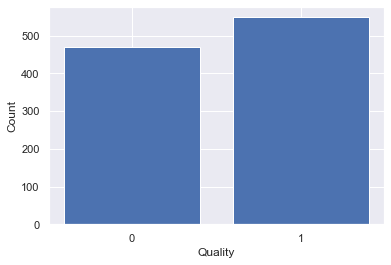

In [4]:
plt.bar(x = wine_data_cleaned['quality'].value_counts().index.tolist(),
       height = wine_data_cleaned['quality'].value_counts())
plt.xlabel('Quality')
plt.ylabel('Count')
plt.xticks([0,1])

<h1>Machine Learning</h1>

We split the dataset into the predictors (X) and the response variable 'quality' (y).

In [5]:
target_label = 'quality'
X = wine_data_cleaned.drop([target_label], axis=1)
y = wine_data_cleaned[target_label]

([<matplotlib.axis.XTick at 0x19045697280>,
 <a list of 2 Text major ticklabel objects>)

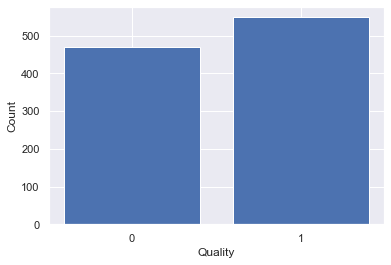

In [6]:
plt.bar(x = y.value_counts().index.tolist(),
       height = y.value_counts())
plt.xlabel('Quality')
plt.ylabel('Count')
plt.xticks([0,1])

<h2> Train Test Split </h2>

We use the train_test_split() function to split the dataset into the train set, and the test set, with a test size of 0.2.
We also specify stratify = y. This is to ensure that the ratio of good:bad values are consistent throughout the train set and the test set.

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state = 42)

<h2>Model Fitting & Hyperparameter Tuning</h2>

For each of the models used below, the GridSearchCV function is used to determine the optimal hyperparameters for each model (i.e. the hyperparameters which result in the highest accuracy scores on the trainset). 5-fold cross validation is used to obtain unbiased results as well as to determine the optimal hyperparameters of each model.

In [9]:
# Importing libraries used for model fitting
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

<H2> (1) Logistic Regression </H2>

Logistic regression is a process of modeling the probability of a discrete outcome given an input variable. Logistic regression is a useful analysis method for classification problems, where you are trying to determine if a new sample fits best into a category. 
It is a simple and more efficient method for binary and linear classification problems. It performs relatively well in our dataset as our response variables are binary. 


In [10]:
param_grid = {'penalty':['l1', 'l2', 'elasticnet'],
              'C': np.logspace(-3, 3, 7),
              'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
             'random_state': [42]}

grid_search_logreg = GridSearchCV(LogisticRegression(), param_grid, cv=KFold(5, shuffle=True, random_state=42), n_jobs=1)
grid_search_logreg.fit(X_train,y_train)
print("Best parameters: ", grid_search_logreg.best_params_)
print("Best CV score: ", grid_search_logreg.best_score_)

best_logreg = LogisticRegression(**grid_search_logreg.best_params_).fit(X_train, y_train)
print("Test accuracy: ", best_logreg.score(X_test, y_test))

Best parameters:  {'C': 1.0, 'penalty': 'l1', 'random_state': 42, 'solver': 'liblinear'}
Best CV score:  0.7361963190184049
Test accuracy:  0.7352941176470589


<h2> (2) Gaussian Naive Bayes </h2>

Naive Bayes methods are a set of supervised learning algorithms based on applying Bayes’ theorem with the “naive” assumption of conditional independence between every pair of features given the value of the class variable. 

For our dataset, we chose to use Gaussian Naive Bayes where the likelihood of each predictor is assumed to be Gaussian (normal distribution).

In [11]:
param_grid = {'var_smoothing': np.logspace(0,-9, num=100),}

grid_search_gnb = GridSearchCV(GaussianNB(), param_grid, cv=KFold(5, shuffle=True, random_state=42), n_jobs=-1)
grid_search_gnb.fit(X_train,y_train)
print("Best parameters: ", grid_search_gnb.best_params_)
print("Best CV score: ", grid_search_gnb.best_score_)

best_gnb = GaussianNB(**grid_search_gnb.best_params_).fit(X_train, y_train)
print("Test accuracy: ", best_gnb.score(X_test, y_test))

Best parameters:  {'var_smoothing': 4.328761281083061e-09}
Best CV score:  0.7276073619631903
Test accuracy:  0.7450980392156863


<h2> (3) Decision Tree Classifier </h2>

The Decision Tree Classifier belongs to the family of supervised learning algorithms. The intuition behind Decision Trees is that you use the dataset features to create yes/no questions and continually split the dataset until you isolate all data points belonging to each class. The Decision Tree classifier can handle both categorical and numerical data (numerical data as predictors in this dataset), and is simple to understand and interpret since the trees can be visualised.

In [12]:
param_grid = {'max_depth':[None, [i for i in range(1,50,1)]],
             'random_state': [42]}

grid_search_dtc = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=KFold(5, shuffle=True, random_state=42), n_jobs=-1)

grid_search_dtc.fit(X_train,y_train)
print("Best parameters: ", grid_search_dtc.best_params_)
print("Best CV score: ", grid_search_dtc.best_score_)

best_dtc = DecisionTreeClassifier(**grid_search_dtc.best_params_).fit(X_train, y_train)
print("Test accuracy: ", best_dtc.score(X_test, y_test))

Best parameters:  {'max_depth': None, 'random_state': 42}
Best CV score:  0.6773006134969325
Test accuracy:  0.6421568627450981


<h2> (4) Random Forest Classifier </h2>

The Random Forest Classifier builds multiple decision trees and merges them together to get a more accurate and stable prediction. One big advantage of random forest is that it can be used for both classification and regression problems, and is suitable for binary classification of wines in this dataset.  Random forest adds additional randomness to the model, while growing the trees. Instead of searching for the most important feature while splitting a node, it searches for the best feature among a random subset of features. This results in a wide diversity that generally results in an improved model.

In [13]:
param_grid = {'max_depth':[i for i in range(1,30,3)],
             'n_estimators': [j for j in range(10, 601, 40)],
             'random_state': [42]}


grid_search_rfc = GridSearchCV(RandomForestClassifier(), param_grid, cv=KFold(5, shuffle=True, random_state=42), n_jobs=-1)

grid_search_rfc.fit(X_train,y_train)
print("Best parameters: ", grid_search_rfc.best_params_)
print("Best CV score: ", grid_search_rfc.best_score_)

best_rfc = RandomForestClassifier(**grid_search_rfc.best_params_).fit(X_train, y_train)
print("Test accuracy: ", best_rfc.score(X_test, y_test))

Best parameters:  {'max_depth': 19, 'n_estimators': 90, 'random_state': 42}
Best CV score:  0.750920245398773
Test accuracy:  0.7254901960784313


<h2> (5) AdaBoost Classifier </h2>

AdaBoost is an iterative ensemble method. AdaBoost classifier builds a strong classifier by combining multiple poorly performing classifiers so that you will get a high accuracy strong classifier. The method automatically adjusts its parameters to the data based on the actual performance in the current iteration, meaning, both the weights for re-weighting the data and the weights for the final aggregation are re-computed iteratively.


In [14]:
param_grid = {'learning_rate':[0.05, 0.1, 0.15, 0.2, 0.25, 0.3],
             'n_estimators': [j for j in range(10, 601, 40)],
             'random_state': [42]}

grid_search_abc = GridSearchCV(AdaBoostClassifier(), param_grid, cv= KFold(5, shuffle=True, random_state=42), n_jobs=-1)

grid_search_abc.fit(X_train,y_train)
print("Best parameters: ", grid_search_abc.best_params_)
print("Best CV score: ", grid_search_abc.best_score_)

best_abc = AdaBoostClassifier(**grid_search_abc.best_params_).fit(X_train, y_train)
print("Test accuracy: ", best_abc.score(X_test, y_test))

Best parameters:  {'learning_rate': 0.15, 'n_estimators': 90, 'random_state': 42}
Best CV score:  0.7435582822085889
Test accuracy:  0.7254901960784313


<h2> (6) CatBoost Classifier </h2>

The CatBoost Classifier is a high-performance open source library for gradient boosting on decision trees. In the growing procedure of the decision trees, CatBoost does not follow similar gradient boosting models. Instead, CatBoost grows oblivious trees, which means that the trees are grown by imposing the rule that all nodes at the same level, test the same predictor with the same condition, and hence an index of a leaf can be calculated with bitwise operations.

In [15]:
from catboost import CatBoostClassifier

param_grid = {'learning_rate': [0.08, 0.1, 0.15, 0.2, 0.25, 0.3], 
             'n_estimators': [200, 250, 300, 350, 400, 450, 500],
             'random_state': [42]}


grid_search_cbc = GridSearchCV(CatBoostClassifier(), param_grid, cv=KFold(5, shuffle=True, random_state=42), n_jobs=-1)

grid_search_cbc.fit(X_train,y_train, silent=True)
print("Best parameters: ", grid_search_cbc.best_params_)
print("Best CV score: ", grid_search_cbc.best_score_)

best_cbc = CatBoostClassifier(**grid_search_cbc.best_params_).fit(X_train, y_train, silent=True)
print("Test accuracy: ", best_cbc.score(X_test, y_test))

0:	learn: 0.6681619	total: 142ms	remaining: 28.2s
1:	learn: 0.6418758	total: 146ms	remaining: 14.5s
2:	learn: 0.6222052	total: 151ms	remaining: 9.91s
3:	learn: 0.5995497	total: 153ms	remaining: 7.51s
4:	learn: 0.5829812	total: 156ms	remaining: 6.07s
5:	learn: 0.5673494	total: 158ms	remaining: 5.1s
6:	learn: 0.5524825	total: 160ms	remaining: 4.41s
7:	learn: 0.5418616	total: 162ms	remaining: 3.88s
8:	learn: 0.5296889	total: 164ms	remaining: 3.47s
9:	learn: 0.5193340	total: 166ms	remaining: 3.15s
10:	learn: 0.5124783	total: 168ms	remaining: 2.88s
11:	learn: 0.5047960	total: 170ms	remaining: 2.66s
12:	learn: 0.4978988	total: 172ms	remaining: 2.47s
13:	learn: 0.4932438	total: 174ms	remaining: 2.31s
14:	learn: 0.4848461	total: 176ms	remaining: 2.17s
15:	learn: 0.4802854	total: 178ms	remaining: 2.05s
16:	learn: 0.4743291	total: 180ms	remaining: 1.94s
17:	learn: 0.4710334	total: 182ms	remaining: 1.84s
18:	learn: 0.4654206	total: 184ms	remaining: 1.75s
19:	learn: 0.4608569	total: 186ms	remainin

171:	learn: 0.1748393	total: 462ms	remaining: 75.1ms
172:	learn: 0.1726024	total: 464ms	remaining: 72.3ms
173:	learn: 0.1715972	total: 465ms	remaining: 69.6ms
174:	learn: 0.1703990	total: 468ms	remaining: 66.8ms
175:	learn: 0.1702673	total: 470ms	remaining: 64.1ms
176:	learn: 0.1690577	total: 472ms	remaining: 61.3ms
177:	learn: 0.1690012	total: 474ms	remaining: 58.6ms
178:	learn: 0.1668001	total: 476ms	remaining: 55.9ms
179:	learn: 0.1648687	total: 479ms	remaining: 53.2ms
180:	learn: 0.1633526	total: 481ms	remaining: 50.5ms
181:	learn: 0.1621420	total: 483ms	remaining: 47.7ms
182:	learn: 0.1609530	total: 485ms	remaining: 45ms
183:	learn: 0.1596126	total: 486ms	remaining: 42.3ms
184:	learn: 0.1573220	total: 488ms	remaining: 39.6ms
185:	learn: 0.1558333	total: 491ms	remaining: 36.9ms
186:	learn: 0.1548992	total: 493ms	remaining: 34.2ms
187:	learn: 0.1535993	total: 495ms	remaining: 31.6ms
188:	learn: 0.1526815	total: 497ms	remaining: 28.9ms
189:	learn: 0.1511320	total: 498ms	remaining: 26

198:	learn: 0.1419284	total: 370ms	remaining: 1.86ms
199:	learn: 0.1413300	total: 372ms	remaining: 0us
Test accuracy:  0.7401960784313726


<h2> (7) GradientBoost Classifier </h2>

Gradient Boosting Classifiers are the AdaBoosting method combined with weighted minimization, after which the classifiers and weighted inputs are recalculated. The objective of Gradient Boosting Classifiers is to minimize the loss, or the difference between the actual class value of the training example and the predicted class value.

In [16]:
param_grid = {'learning_rate':[0.008, 0.1, 0.12, 0.14, 0.16, 0.18, 0.2, 0.22, 0.24], 
             'n_estimators': [100, 150, 200, 250, 300, 350, 400, 500, 550, 600],
             'random_state': [42]}

grid_search_gbc = GridSearchCV(GradientBoostingClassifier(), param_grid, cv=KFold(5, shuffle=True, random_state=42), n_jobs=-1)

grid_search_gbc.fit(X_train,y_train)
print("Best parameters: ", grid_search_gbc.best_params_)
print("Best CV score: ", grid_search_gbc.best_score_)

best_gbc = GradientBoostingClassifier(**grid_search_gbc.best_params_).fit(X_train, y_train)
print("Test accuracy: ", best_gbc.score(X_test, y_test))

Best parameters:  {'learning_rate': 0.008, 'n_estimators': 300, 'random_state': 42}
Best CV score:  0.7374233128834357
Test accuracy:  0.7352941176470589


<h2> Conclusion </h2>

Using the dataset with no duplicates and outliers removed, we note that the Naive Bayes Classifier performs the best with a classification accuracy of 74.51%.